In [2]:
import torch
import torch.nn.functional as F
import itertools
from functools import partial
import heapq
from collections import namedtuple, defaultdict
import pandas as pd
import numpy as np
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from  torch_geometric.transforms.distance import Distance 
import matplotlib.pyplot as plt


In [2]:
def neighbours_8(x, y, x_max, y_max):
    deltas_x = (-1, 0, 1)
    deltas_y = (-1, 0, 1)
    for (dx, dy) in itertools.product(deltas_x, deltas_y):
        x_new, y_new = x + dx, y + dy
        if 0 <= x_new < x_max and 0 <= y_new < y_max and (dx, dy) != (0, 0):
            yield x_new, y_new

In [3]:
def Dijkstra(matrices, neighbourhood_fn=neighbours_8, request_transitions=False): # Shortest path finder
        batch_size, height, width = matrices.size()
        outputs = []

        for batch_idx in range(batch_size):
            matrix = matrices[batch_idx]  # Extract the current matrix
            x_max, y_max = matrix.shape
            neighbors_func = partial(neighbourhood_fn, x_max=x_max, y_max=y_max)

            costs = torch.full_like(matrix, 1.0e10)
            costs[0][0] = matrix[0][0]
            num_path = torch.zeros_like(matrix)
            num_path[0][0] = 1
            priority_queue = [(matrix[0][0], (0, 0))]
            certain = set()
            transitions = defaultdict(tuple)

            while priority_queue:
                cur_cost, (cur_x, cur_y) = heapq.heappop(priority_queue)
                if (cur_x, cur_y) in certain:
                    pass

                for x, y in neighbors_func(cur_x, cur_y):
                    if (x, y) not in certain:
                        if matrix[x][y] + costs[cur_x][cur_y] < costs[x][y]:
                            costs[x][y] = matrix[x][y] + costs[cur_x][cur_y]
                            heapq.heappush(priority_queue, (costs[x][y], (x, y)))
                            transitions[(x, y)] = (cur_x, cur_y)
                            num_path[x, y] = num_path[cur_x, cur_y]
                        elif matrix[x][y] + costs[cur_x][cur_y] == costs[x][y]:
                            num_path[x, y] += 1

                certain.add((cur_x, cur_y))
            
            # Retrieve the path
            cur_x, cur_y = x_max - 1, y_max - 1
            on_path = torch.zeros_like(matrix)
            on_path[-1][-1] = 1
            while (cur_x, cur_y) != (0, 0):
                cur_x, cur_y = transitions[(cur_x, cur_y)]
                on_path[cur_x, cur_y] = 1.0

            outputs.append(on_path.unsqueeze(0))

        return torch.stack(outputs).squeeze(1).requires_grad_(True)

Write a new function, Dijkstra_graph() that takes a Graph object as input. Previously, Dijkstra would calculate the shortest path using the output of the CNN that embeds the image. Now we are embedding the image with a GNN. Dijkstra will use these node embeddings.

In [3]:
graph = torch.load("/home/duser/masters_project/data/new_g.pt")
graph.x = torch.randn(123)
print(graph)

Data(edge_index=[2, 656], labels=[123, 1], pixel count=[123], total color=[123, 3], mean color=[123, 3], centroid=[123, 2], weight=[656], num_nodes=123, x=[123])


In [4]:
print(graph.edge_index[:, -10:])
print(graph.centroid[-10:])

tensor([[120, 120, 120, 120, 121, 121, 121, 121, 122, 122],
        [100, 111, 115, 118, 110, 113, 119, 122, 113, 121]])
tensor([[86.2941, 91.4118],
        [89.7692, 16.9538],
        [87.3200, 27.7000],
        [89.9467,  3.0133],
        [90.0723, 10.0120],
        [91.7857, 24.3857],
        [91.2276, 73.6667],
        [91.9293, 36.9192],
        [92.5227, 85.0455],
        [92.5000, 92.0000]], dtype=torch.float64)


In [5]:
neighbours = [[i] for i in (graph.edge_index[0] == 0).nonzero(as_tuple=True)[0].tolist()] # Checked this is correct
print(neighbours)
print(neighbours[np.argmin([graph.edge_attr[i].item() for i in neighbours])]) # Index of neighbour with shortest dist
print(min([graph.edge_attr[i].item() for i in neighbours])) # Dist from source node to nearest neighbor
print([graph.edge_index[1][i].item() for i in neighbours])

[[0], [1], [2]]


TypeError: 'NoneType' object is not subscriptable

In [8]:
import torch_geometric as pyg 
import networkx as nx

nx_graph = pyg.utils.to_networkx(graph)
path = torch.tensor(nx.shortest_path(nx_graph, source=0, target=122))
path

tensor([  0,  23,  26,  46,  60,  67,  76,  83,  99, 106, 119, 121, 122])

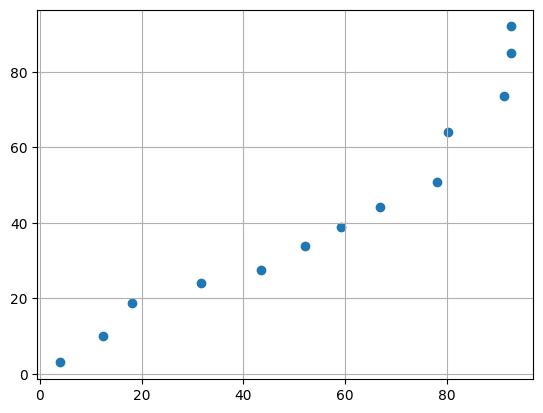

In [ ]:
# [0, 23, 26, 46, 60, 67, 76, 83, 99, 106, 119, 121, 122]
grid = np.zeros((11,11))

for ele in nx.shortest_path(nx_graph, source=0, target=122):
    i = ele // 11 # This is the row 
    j = ele % 11 # This is the column  

    if i % 2 != 0:
        j=-j

    try:
        grid[i,j] = 1
    except IndexError:
        pass

#plt.imshow(grid)
#using the indices visualise the position of the centroids


#image = 
plt.scatter(graph.centroid[path,0], graph.centroid[path,1])
plt.grid(markevery=5)

In [7]:
def Dijkstra_graph(graph_obj, source=0, target=123): # Shortest path finder with graph input

    """
    edge_index = graph.edge_index
    edge_attr = graph.edge_attr

    
    source = 1 # Node with label 1
    destination = 123 # PERCEIVED destination node (must check)
    cost = []
    prev = []
    Q = [] # Set of vertices that have the least dist[v] value

    for node in graph.labels:
        cost[node] = torch.inf
        Q.append(node)
    cost[source] = 0

    while len(Q) != 0:
        u = Q[0] # Will update per loop
        # Need node u and the index of its neighbours according to their place in 'edge_index'
        neighbours_index = (edge_index[0] == u).nonzero(as_tuple=True)[0].item
        u = neighbours_index[torch.argmin([edge_attr[i] for i in neighbours_index])]
        Q = Q[1:] # Remove u from Q

        for v in neighbours_index:
            if v in Q:
                alt = min([graph.edge_attr[i].item() for i in neighbours_index])
    """

    # Turn Graph object into adjacency list
    # E.g: {'1': {neighbour1 : dist_to_neighbour1,
    #             neighbour2 : dist_to_neighbour2....}
    #       '2': {...}}
    graph = {node: {graph_obj.edge_index[1][neighbor_index].item(): graph_obj.x[node].item() for neighbor_index in [[i] for i in (graph_obj.edge_index[0] == node).nonzero(as_tuple=True)[0].tolist()]} for node in range(target)}
    import pdb; pdb.set_trace()

    # Initialize distances and paths
    distances = {node: float('inf') for node in range(target)}
    paths = {node: [] for node in range(target)}

    # Priority queue for Dijkstra's algorithm
    priority_queue = [(0, source, [source])]
    
    while priority_queue:
        current_distance, current_node, current_path = heapq.heappop(priority_queue)
        
        # Check if the current path is shorter than the known path to the current node
        if current_distance < distances[current_node]:
            distances[current_node] = current_distance
            paths[current_node] = current_path
            
            # Explore neighbors
            for neighbor, weight in graph[current_node].items():
                heapq.heappush(priority_queue, (current_distance + weight, neighbor, current_path + [neighbor]))
    
    # Return all shortest paths to the target node
    return distances[target], paths[target]


"""# Example graph represented as an adjacency list
graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 5},
    'C': {'A': 4, 'B': 2, 'D': 1},
    'D': {'B': 5, 'C': 1}
}

source_node = 'A'
target_node = 'D'"""

shortest_distance, shortest_paths = Dijkstra_graph(graph)

print(f"Shortest Distance from {1} to {122}: {shortest_distance}")
print(f"All Shortest Paths: {shortest_paths}")

> /tmp/ipykernel_2667719/3568162201.py(39)Dijkstra_graph()
     37 
     38     # Initialize distances and paths
---> 39     distances = {node: float('inf') for node in range(target)}
     40     paths = {node: [] for node in range(target)}
     41 



: 

In [ ]:
plt.plot()